In [1]:
# =========================================
#  1. 安裝與載入常用套件
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc
)

# 顯示圖形在Colab中
%matplotlib inline


In [2]:
# =========================================
#  2. 讀取資料
# =========================================
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/heart_failure_clinical_records_dataset.csv")
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# =========================================
#  3. 基本資料探索
# =========================================
print(df.info())
print(df.describe())

# 檢查是否有缺失值
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
None
             

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


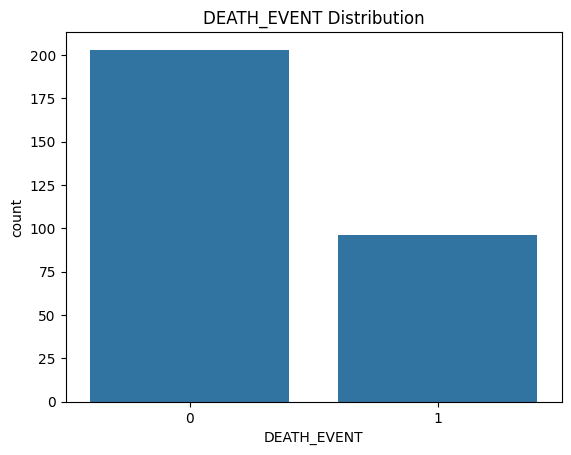

In [4]:
# =========================================
#  4. 觀察 y 的分佈（是否資料不平衡）
# =========================================
sns.countplot(data=df, x="DEATH_EVENT")
plt.title("DEATH_EVENT Distribution")
plt.show()


In [5]:
# =========================================
#  5. 切分訓練集/測試集
# =========================================
X = df.drop(["time", "DEATH_EVENT"], axis=1)
y = df["DEATH_EVENT"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.info())
print(X_test.info())
# print(X_train.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 115 to 28
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 274 to 145
Data columns (total 11 columns):
 #   Column                

In [6]:
# =========================================
#  6. 建立 Random Forest 模型
# =========================================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # 讓少數類別多一點權重
)

rf.fit(X_train, y_train)


# 預測
y_pred = rf.predict(X_test)


In [7]:
# =========================================
# A. 所有測試樣本的投票狀況
# =========================================

# 取得所有樹對 X_test 的預測結果
# votes 的 shape = (n_trees, n_samples)
votes = np.array([est.predict(X_test) for est in rf.estimators_])

# 計算每個樣本被投 0 / 1 的次數
vote_0_counts = np.sum(votes == 0, axis=0)  # 每一欄是一個樣本
vote_1_counts = np.sum(votes == 1, axis=0)

# RandomForest 的最終預測
rf_pred = rf.predict(X_test)

# 做成表格方便檢視
vote_df = pd.DataFrame({
    "true_label": y_test.values,
    "rf_pred": rf_pred,
    "vote_0": vote_0_counts,
    "vote_1": vote_1_counts
})

# 如果欄位 index 不漂亮，可以 reset_index
vote_df = vote_df.reset_index(drop=True)

# 只顯示前 10 筆看看（全部要看就把 head(10) 改成 vote_df）
vote_df.head(10)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: U

,true_label,rf_pred,vote_0,vote_1
0,0,0,184,116
1,0,0,270,30
2,0,0,200,100
3,0,1,119,181
4,0,0,239,61
5,0,0,210,90
6,0,0,276,24
7,1,1,144,156
8,0,0,272,28
9,0,1,51,249


===== 隨機選擇的測試樣本 =====
      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
117  85.0        1                       102         0                 60   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
117                    0   507000.0               3.2           138    0   

     smoking  
117        0  
真實標籤 (y_test): 0
----------------------------------
第 1 棵樹的預測： 0.0
第 2 棵樹的預測： 0.0
第 3 棵樹的預測： 0.0
第 4 棵樹的預測： 1.0
第 5 棵樹的預測： 1.0
第 6 棵樹的預測： 0.0
第 7 棵樹的預測： 1.0
第 8 棵樹的預測： 1.0
第 9 棵樹的預測： 0.0
第 10 棵樹的預測： 1.0
第 11 棵樹的預測： 0.0
第 12 棵樹的預測： 0.0
第 13 棵樹的預測： 1.0
第 14 棵樹的預測： 1.0
第 15 棵樹的預測： 1.0
第 16 棵樹的預測： 1.0
第 17 棵樹的預測： 1.0
第 18 棵樹的預測： 0.0
第 19 棵樹的預測： 1.0
第 20 棵樹的預測： 1.0
第 21 棵樹的預測： 1.0
第 22 棵樹的預測： 0.0
第 23 棵樹的預測： 1.0
第 24 棵樹的預測： 1.0
第 25 棵樹的預測： 1.0
第 26 棵樹的預測： 1.0
第 27 棵樹的預測： 1.0
第 28 棵樹的預測： 0.0
第 29 棵樹的預測： 1.0
第 30 棵樹的預測： 1.0
第 31 棵樹的預測： 1.0
第 32 棵樹的預測： 1.0
第 33 棵樹的預測： 0.0
第 34 棵樹的預測： 1.0
第 35 棵樹的預測： 0.0
第 36 棵樹的預測： 1.0
第 37 棵樹的預測： 0.0
第 38 

<BarContainer object of 2 artists>

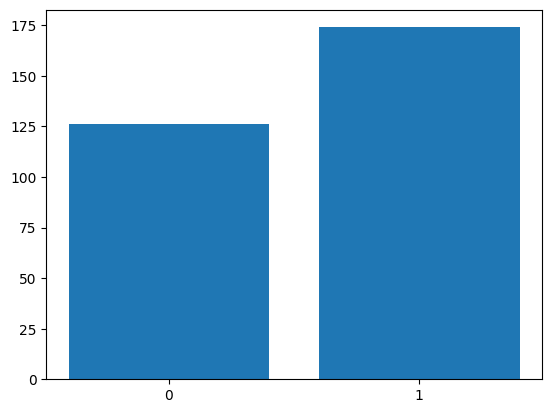

In [8]:
# =========================================
# 顯示隨機森林中每棵樹的投票過程
# =========================================
import numpy as np
import random

# 隨機選擇一個測試資料索引
idx = random.randint(0, len(X_test)-1)
sample = X_test.iloc[idx:idx+1]

print("===== 隨機選擇的測試樣本 =====")
print(sample)
print("真實標籤 (y_test):", y_test.iloc[idx])
print("----------------------------------")

# 每棵樹的預測
tree_votes = []
for i, estimator in enumerate(rf.estimators_):
    # pred = estimator.predict(sample)[0]
    pred = estimator.predict(sample.values)[0]
    tree_votes.append(pred)
    print(f"第 {i+1} 棵樹的預測： {pred}")

print("----------------------------------")
tree_votes = np.array(tree_votes)
vote_0 = np.sum(tree_votes == 0)
vote_1 = np.sum(tree_votes == 1)

print(f"投票結果： 0 = {vote_0} 票，1 = {vote_1} 票")

# 隨機森林多數決結果
final_pred = rf.predict(sample)[0]
print("RandomForest 最終預測 =", final_pred)
plt.bar(["0", "1"], [vote_0, vote_1])

In [9]:
# =========================================
#  7. 評估模型
# =========================================
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7333333333333333

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        41
           1       0.62      0.42      0.50        19

    accuracy                           0.73        60
   macro avg       0.69      0.65      0.66        60
weighted avg       0.72      0.73      0.72        60



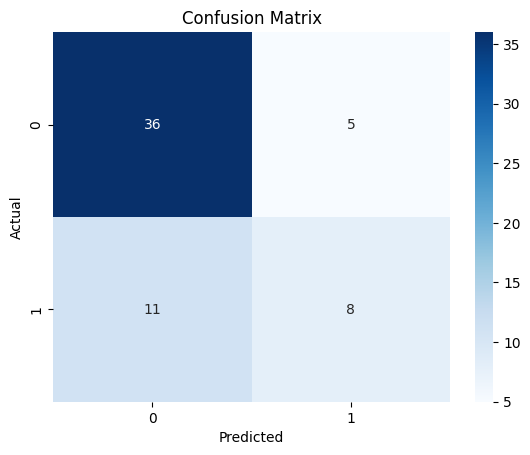

In [10]:
# =========================================
#  8. 混淆矩陣
# =========================================
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


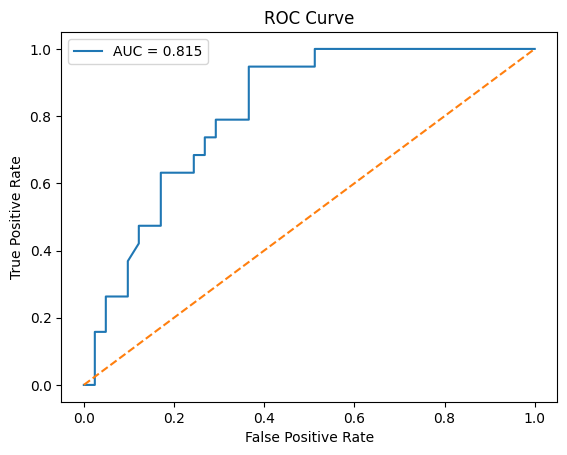

In [11]:
# =========================================
#  9. ROC 曲線 + AUC
# =========================================
y_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


/tmp/ipython-input-277013486.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi, x="importance", y="feature", palette="viridis")


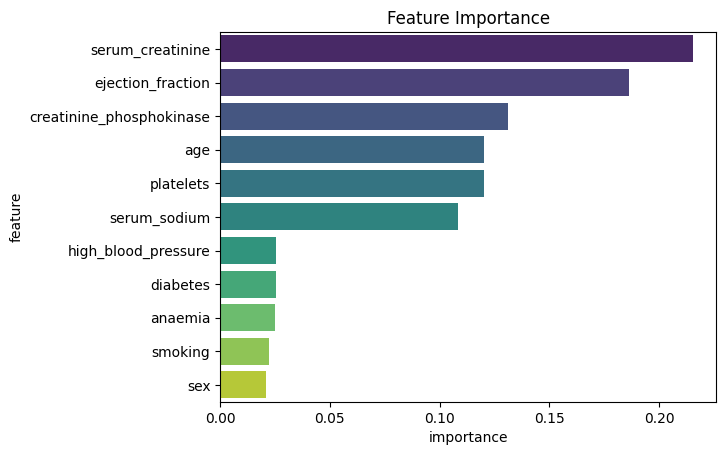

In [12]:
# =========================================
#  10. 特徵重要度
# =========================================
importances = rf.feature_importances_
feature_names = X.columns

fi = pd.DataFrame({"feature": feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)

sns.barplot(data=fi, x="importance", y="feature", palette="viridis")
plt.title("Feature Importance")
plt.show()


In [13]:
# =========================================
#  11. 超參數調整（GridSearchCV）
# =========================================
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.629946501403676


In [14]:
# =========================================
#  12. 交叉驗證 (5-fold)
# =========================================
scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")
print("Cross-validation Accuracy:", scores)
print("Mean Accuracy:", scores.mean())


Cross-validation Accuracy: [0.73333333 0.65       0.73333333 0.78333333 0.74576271]
Mean Accuracy: 0.7291525423728814
